In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
# import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence


Using TensorFlow backend.


In [3]:
import sys
import tensorflow as tf
import SimpleITK as sitk
import dltk
import math
from myshow import myshow
from tensorflow.python.framework import ops
import pylab as py
import matplotlib.pyplot as plt

In [4]:
gpu = 0,1

shape = (256, 256, 256)

##### training parameters #####
# number of folds
# k_folds = 7
# batch size
# i.e. number of samples per training step
# validation always uses b = 1
b = 50 
# number of epochs
# i.e. times to loop over the entire set

In [5]:
from sklearn.metrics import recall_score

# metrics
def specificity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0,average='weighted')


def sensitivity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1,average='weighted')


def balanced_accuracy(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    return (spec + sens) / 2

In [6]:
# Start timing
start_time = time.time()

In [7]:
# # Tensorflow settings
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session, get_session

# config = tf.ConfigProto(device_count={'gpu':"0"})
# config.gpu_options.allow_growth = True
# # config.gpu_options.visible_device_list = "6" #?????? 6
# sess = tf.Session(config=config)
# set_session(sess)

In [8]:
import tensorflow as tf
def decode2(serialized_example):
    # Decode examples stored in TFRecord
    # NOTE: make sure to specify the correct dimensions for the images
    features = tf.parse_single_example(
        serialized_example,
        features={'image': tf.FixedLenFeature([256, 256, 1], tf.float32),
                  'label': tf.FixedLenFeature([], tf.int64),
                  'name': tf.FixedLenFeature([],tf.string)})
    
    images = features['image'] 
    labels = features['label']
    names = features['name']
    # NOTE: No need to cast these features, as they are already `tf.float32` values.
    return images, labels,names

In [9]:
labels = pd.read_csv("nii_with_binary_label.csv")
CN_files = labels[labels['CN']==1].iloc[:,1] #Category label 1
EMCI_files = labels[labels['EMCI']==1].iloc[:,1] #Category label 2
MCI_files = labels[labels['MCI']==1].iloc[:,1] #Category label 3
LMCI_files = labels[labels['LMCI']==1].iloc[:,1] #Category label 4
AD_files = labels[labels['AD']==1].iloc[:,1] #Category label 5
SMC_files = labels[labels['SMC']==1].iloc[:,1] #Category label 6

In [10]:
all_AD_x = tf.data.TFRecordDataset("x_AD.tfrecords").shuffle(10000,seed=1)
all_CN_x = tf.data.TFRecordDataset("x_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_x = tf.data.TFRecordDataset("x_MCI.tfrecords").shuffle(10000,seed=1)
all_EMCI_x = tf.data.TFRecordDataset("x_EMCI.tfrecords").shuffle(10000,seed=1)
all_LMCI_x = tf.data.TFRecordDataset("x_LMCI.tfrecords").shuffle(10000,seed=1)
all_SMC_x = tf.data.TFRecordDataset("x_SMC.tfrecords").shuffle(10000,seed=1)

test_AD_x = all_AD_x.take(int(len(AD_files)*0.2)) 
train_AD_x = all_AD_x.skip(int(len(AD_files)*0.2))
train_AD_re_x = train_AD_x.repeat(3)

test_CN_x = all_CN_x.take(int(len(CN_files)*0.2)) 
train_CN_x = all_CN_x.skip(int(len(CN_files)*0.2))

test_MCI_x = all_MCI_x.take(int(len(MCI_files)*0.2)) 
train_MCI_x = all_MCI_x.skip(int(len(MCI_files)*0.2))

test_EMCI_x = all_EMCI_x.take(int(len(EMCI_files)*0.2)) 
train_EMCI_x = all_EMCI_x.skip(int(len(EMCI_files)*0.2))
train_EMCI_re_x = train_EMCI_x.repeat(2)

test_LMCI_x = all_LMCI_x.take(int(len(LMCI_files)*0.2)) 
train_LMCI_x = all_LMCI_x.skip(int(len(LMCI_files)*0.2))
train_LMCI_re_x = train_LMCI_x.repeat(3)

test_SMC_x = all_SMC_x.take(int(len(SMC_files)*0.2)) 
train_SMC_x = all_SMC_x.skip(int(len(SMC_files)*0.2))
train_SMC_re_x = train_SMC_x.repeat(9)



train_2cls_tra_x = train_MCI_x.concatenate(train_AD_re_x)
test_2cls_x = test_MCI_x.concatenate(test_AD_x)

train_2cls_tra_x = train_2cls_tra_x.map(decode2).batch(batch_size=50000)
test_2cls_x = test_2cls_x.map(decode2).batch(batch_size = 10000)

iterator_train_x = train_2cls_tra_x.make_initializable_iterator()
features_x,labels_x,names_x = iterator_train_x.get_next()

iterator_test_x = test_2cls_x.make_initializable_iterator()
features_te_x,labels_te_x,names_te_x = iterator_test_x.get_next()

# train_6cls = train_AD_re.concatenate(train_CN).concatenate(train_MCI).concatenate(train_LMCI_re).concatenate(train_EMCI_re).concatenate(train_SMC_re)
# test_6cls = test_AD.concatenate(test_CN).concatenate(test_MCI).concatenate(test_LMCI).concatenate(test_EMCI).concatenate(test_SMC)
# train_6cls = train_6cls.map(decode2).shuffle(5000000).batch(batch_size=100000).repeat()
# test_6cls = test_6cls.map(decode2).batch(batch_size = 21000)
# iterator_train_6 = train_6cls.make_initializable_iterator()
# iterator_test_6 = test_6cls.make_initializable_iterator()
# features6,labels6,names6 = iterator_train_6.get_next()
# ftest6,ltest6,ntest6=iterator_test_6.get_next()



Instructions for updating:
Colocations handled automatically by placer.


In [11]:
all_AD_y = tf.data.TFRecordDataset("y_AD.tfrecords").shuffle(10000,seed=1)
all_CN_y = tf.data.TFRecordDataset("y_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_y = tf.data.TFRecordDataset("y_MCI.tfrecords").shuffle(10000,seed=1)
all_EMCI_y = tf.data.TFRecordDataset("y_EMCI.tfrecords").shuffle(10000,seed=1)
all_LMCI_y = tf.data.TFRecordDataset("y_LMCI.tfrecords").shuffle(10000,seed=1)
all_SMC_y = tf.data.TFRecordDataset("y_SMC.tfrecords").shuffle(10000,seed=1)

test_AD_y = all_AD_y.take(int(len(AD_files)*0.2)) 
train_AD_y = all_AD_y.skip(int(len(AD_files)*0.2))
train_AD_re_y = train_AD_y.repeat(3)

test_CN_y = all_CN_y.take(int(len(CN_files)*0.2)) 
train_CN_y = all_CN_y.skip(int(len(CN_files)*0.2))

test_MCI_y = all_MCI_y.take(int(len(MCI_files)*0.2)) 
train_MCI_y = all_MCI_y.skip(int(len(MCI_files)*0.2))

test_EMCI_y = all_EMCI_y.take(int(len(EMCI_files)*0.2)) 
train_EMCI_y = all_EMCI_y.skip(int(len(EMCI_files)*0.2))
train_EMCI_re_y = train_EMCI_y.repeat(2)

test_LMCI_y = all_LMCI_y.take(int(len(LMCI_files)*0.2)) 
train_LMCI_y = all_LMCI_y.skip(int(len(LMCI_files)*0.2))
train_LMCI_re_y = train_LMCI_y.repeat(3)

test_SMC_y = all_SMC_y.take(int(len(SMC_files)*0.2)) 
train_SMC_y = all_SMC_y.skip(int(len(SMC_files)*0.2))
train_SMC_re_y = train_SMC_y.repeat(9)

train_2cls_tra_y= train_MCI_y.concatenate(train_AD_re_y)
test_2cls_y = test_MCI_y.concatenate(test_AD_y)

train_2cls_tra_y = train_2cls_tra_y.map(decode2).batch(batch_size=50000)
test_2cls_y = test_2cls_y.map(decode2).batch(batch_size = 10000)

iterator_train_y = train_2cls_tra_y.make_initializable_iterator()
features_y,labels_y,names_y = iterator_train_y.get_next()

iterator_test_y = test_2cls_y.make_initializable_iterator()
features_te_y,labels_te_y,names_te_y = iterator_test_y.get_next()

In [12]:
all_AD_z = tf.data.TFRecordDataset("z_AD.tfrecords").shuffle(10000,seed=1)
all_CN_z = tf.data.TFRecordDataset("z_CN.tfrecords").shuffle(10000,seed=1)
all_MCI_z = tf.data.TFRecordDataset("z_MCI.tfrecords").shuffle(10000,seed=1)
all_EMCI_z = tf.data.TFRecordDataset("z_EMCI.tfrecords").shuffle(10000,seed=1)
all_LMCI_z = tf.data.TFRecordDataset("z_LMCI.tfrecords").shuffle(10000,seed=1)
all_SMC_z = tf.data.TFRecordDataset("z_SMC.tfrecords").shuffle(10000,seed=1)

test_AD_z = all_AD_z.take(int(len(AD_files)*0.2)) 
train_AD_z = all_AD_z.skip(int(len(AD_files)*0.2))
train_AD_re_z = train_AD_z.repeat(3)

test_CN_z = all_CN_z.take(int(len(CN_files)*0.2)) 
train_CN_z = all_CN_z.skip(int(len(CN_files)*0.2))

test_MCI_z = all_MCI_z.take(int(len(MCI_files)*0.2)) 
train_MCI_z = all_MCI_z.skip(int(len(MCI_files)*0.2))

test_EMCI_z = all_EMCI_z.take(int(len(EMCI_files)*0.2)) 
train_EMCI_z = all_EMCI_z.skip(int(len(EMCI_files)*0.2))
train_EMCI_re_z = train_EMCI_z.repeat(2)

test_LMCI_z = all_LMCI_z.take(int(len(LMCI_files)*0.2)) 
train_LMCI_z = all_LMCI_z.skip(int(len(LMCI_files)*0.2))
train_LMCI_re_z = train_LMCI_z.repeat(3)

test_SMC_z = all_SMC_z.take(int(len(SMC_files)*0.2)) 
train_SMC_z = all_SMC_z.skip(int(len(SMC_files)*0.2))
train_SMC_re_z = train_SMC_z.repeat(9)

train_2cls_tra_z= train_MCI_z.concatenate(train_AD_re_z)
test_2cls_z = test_MCI_z.concatenate(test_AD_z)

train_2cls_tra_z = train_2cls_tra_z.map(decode2).batch(batch_size=50000)
test_2cls_z = test_2cls_z.map(decode2).batch(batch_size = 10000)

iterator_train_z = train_2cls_tra_z.make_initializable_iterator()
features_z,labels_z,names_z = iterator_train_z.get_next()

iterator_test_z = test_2cls_z.make_initializable_iterator()
features_te_z,labels_te_z,names_te_z = iterator_test_z.get_next()

In [13]:
with tf.Session() as sess:
    sess.run(iterator_train_x.initializer)
    sess.run(iterator_test_x.initializer)
    X_train_x,y_train_x = sess.run([features_x, labels_x])
    X_test_x,y_test_x,names_x=sess.run([features_te_x,labels_te_x,names_te_x])

In [14]:
with tf.Session() as sess:
    sess.run(iterator_train_y.initializer)
    sess.run(iterator_test_y.initializer)
    X_train_y,y_train_y = sess.run([features_y, labels_y])
    X_test_y,y_test_y,names_y=sess.run([features_te_y,labels_te_y,names_te_y])

In [15]:
with tf.Session() as sess:
    sess.run(iterator_train_z.initializer)
    sess.run(iterator_test_z.initializer)
    X_train_z,y_train_z = sess.run([features_z, labels_z])
    X_test_z,y_test_z,names_z=sess.run([features_te_z,labels_te_z,names_te_z])

In [16]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, 
                     input_shape=(int(input_shape[1]), int(input_shape[2]), int(input_shape[3])), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling2D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv2D(16, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling2D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv2D(32, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv2D(16, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling2D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=2, activation='sigmoid'))
    return model

# x_axis

In [17]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_Y_x = encoder.fit_transform(y_train_x)
encoded_Y_test_x = encoder.fit_transform(y_test_x)
# convert integers to dummy variables (one hot encoding)
y_train_x = np_utils.to_categorical(encoded_Y_x)
y_test_x = np_utils.to_categorical(encoded_Y_test_x)

In [18]:
X_train_x.shape
y_train_x.shape

(5143, 2)

In [19]:
X_test_x.shape
y_test_x.shape

(788, 2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 5143 samples, validate on 788 samples
Epoch 1/150
5143/5143 [==============================] - 13s 3ms/step - loss: 1.4712 - acc: 0.5282 - val_loss: 1.1285 - val_acc: 0.3312
Epoch 2/150
5143/5143 [==============================] - 8s 2ms/step - loss: 1.0548 - acc: 0.5450 - val_loss: 1.0983 - val_acc: 0.3147
Epoch 3/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.9782 - acc: 0.5652 - val_loss: 1.0156 - val_acc: 0.3293
Epoch 4/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.9147 - acc: 0.5854 - val_loss: 0.9451 - val_acc: 0.3471
Epoch 5/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.8509 - acc: 0.6111 - val_loss: 0.8638 - val_acc: 0.5431
Epoch 6/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.7988 - acc: 0.6274 - val_loss: 0.85

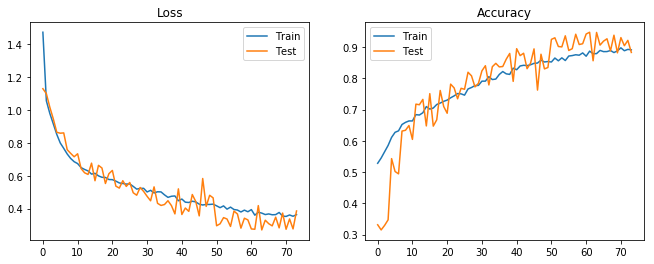

In [20]:
%matplotlib inline
from keras.utils import multi_gpu_model

num_epochs = 150

result_dir=''
# training args
lr = 0.001
lr_decay = 0.

num_trials = 1
patience = 10
store_models = True

best_epoch_acc = []


for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train_x.shape)
    model=multi_gpu_model(model,2)

    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_admci_x_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    history = model.fit(
        X_train_x,
        y_train_x,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_test_x,y_test_x),
        callbacks=callbacks,
        shuffle=True
    )
    
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Test"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Test"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation

    y_pred_x = model.predict(X_test_x, batch_size=1)

    
    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])

In [21]:
sens0 = sensitivity(y_test_x[:,0], (y_pred_x[:,0]>0.5)*1)
sens1 = sensitivity(y_test_x[:,1], (y_pred_x[:,1]>0.5)*1)
# sens2 = sensitivity(y_test[:,2], (y_pred[:,2]>0.5)*1)
# sens3 = sensitivity(y_test[:,3], (y_pred[:,3]>0.5)*1)
# sens4 = sensitivity(y_test[:,4], (y_pred[:,4]>0.5)*1)
# sens5 = sensitivity(y_test[:,5], (y_pred[:,5]>0.5)*1)
print(sens0,sens1)

0.883248730964467 0.883248730964467


In [22]:
sens0 = specificity(y_test_x[:,0], (y_pred_x[:,0]>0.5)*1)
sens1 = specificity(y_test_x[:,1], (y_pred_x[:,1]>0.5)*1)
# sens2 = specificity(y_test[:,2], (y_pred[:,2]>0.5)*1)
# sens3 = specificity(y_test[:,3], (y_pred[:,3]>0.5)*1)
# sens4 = specificity(y_test[:,4], (y_pred[:,4]>0.5)*1)
# sens5 = specificity(y_test[:,5], (y_pred[:,5]>0.5)*1)
print(sens0,sens1)

0.883248730964467 0.883248730964467


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1052: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [23]:
# model.summary()

In [24]:
# # sens=model.evaluate(X_train, y_pred, verbose=0)
# import keras
# keras.metrics.categorical_accuracy(y_train, y_pred.reshape(3418,2))

# # categorical_accuracy(y_true, y_pred)


In [25]:
## acc 
for i in range(2):
    print(np.mean(y_test_x[:,i]==((y_pred_x>=0.5)[:,i])*1))

0.883248730964467
0.883248730964467


In [26]:
##tp
for i in range(2):
    print(np.sum((y_pred_x[:,i]>=0.5)*1+y_test_x[:,i]==2)/np.sum(y_test_x[:,i]==1))

0.8314814814814815
0.9919354838709677


In [27]:
##precision

for i in range(2):
    print(np.sum((y_pred_x[:,i]>=0.5)*1+y_test_x[:,i]==2)/np.sum((y_pred_x[:,i]>=0.5)*1==1))

0.9977777777777778
0.7321428571428571


# y_axis

In [28]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_Y_y = encoder.fit_transform(y_train_y)
encoded_Y_test_y = encoder.fit_transform(y_test_y)
# convert integers to dummy variables (one hot encoding)
y_train_y = np_utils.to_categorical(encoded_Y_y)
y_test_y = np_utils.to_categorical(encoded_Y_test_y)

Train on 5143 samples, validate on 788 samples
Epoch 1/150
5143/5143 [==============================] - 10s 2ms/step - loss: 1.4347 - acc: 0.5264 - val_loss: 1.2599 - val_acc: 0.3154
Epoch 2/150
5143/5143 [==============================] - 8s 2ms/step - loss: 1.0615 - acc: 0.5353 - val_loss: 1.0480 - val_acc: 0.3280
Epoch 3/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.9908 - acc: 0.5571 - val_loss: 1.0537 - val_acc: 0.3147
Epoch 4/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.9341 - acc: 0.5672 - val_loss: 1.0058 - val_acc: 0.3147
Epoch 5/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.8895 - acc: 0.5746 - val_loss: 0.9055 - val_acc: 0.3940
Epoch 6/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.8498 - acc: 0.5713 - val_loss: 0.9370 - val_acc: 0.3173
Epoch 7/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.8114 - acc: 0.5919 - val_loss: 0.9405 - val_acc: 0.3166
Epoch 8

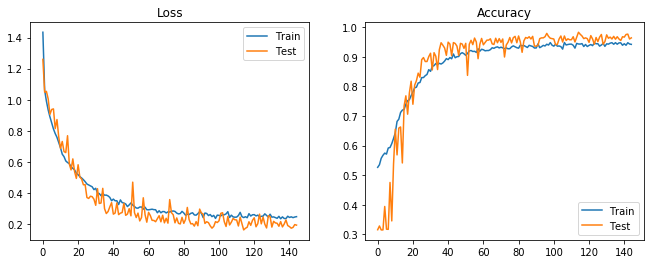

In [45]:
%matplotlib inline
from keras.utils import multi_gpu_model

num_epochs = 150

result_dir=''
# training args
lr = 0.001
lr_decay = 0.

num_trials = 1
patience = 30
store_models = True

best_epoch_acc = []
# final_epoch_sens0 = []
# final_epoch_sens1 = []
# final_epoch_sens2 = []
# final_epoch_sens3 = []
# final_epoch_sens4 = []
# final_epoch_sens5 = []

# final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train_y.shape)
    model=multi_gpu_model(model,2)

    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_admci_y_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    history = model.fit(
        X_train_y,
        y_train_y,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_test_y,y_test_y),
        callbacks=callbacks,
        shuffle=True
    )
    
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Test"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Test"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation

    y_pred_y = model.predict(X_test_y, batch_size=1)


    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])


In [46]:
y_pred_y = model.predict(X_test_y, batch_size=1)
## acc 
for i in range(2):
    print(np.mean(y_test_y[:,i]==((y_pred_y>=0.5)[:,i])*1))

0.9644670050761421
0.9644670050761421


In [47]:
##tp
for i in range(2):
    print(np.sum((y_pred_y[:,i]>=0.5)*1+y_test_y[:,i]==2)/np.sum(y_test_y[:,i]==1))

0.95
0.9959677419354839


In [48]:
##precision

for i in range(2):
    print(np.sum((y_pred_y[:,i]>=0.5)*1+y_test_y[:,i]==2)/np.sum((y_pred_y[:,i]>=0.5)*1==1))

0.9980544747081712
0.9014598540145985


# z axis

In [33]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_Y_z = encoder.fit_transform(y_train_z)
encoded_Y_test_z = encoder.fit_transform(y_test_z)
# convert integers to dummy variables (one hot encoding)
y_train_z = np_utils.to_categorical(encoded_Y_z)
y_test_z = np_utils.to_categorical(encoded_Y_test_z)

Train on 5143 samples, validate on 788 samples
Epoch 1/150
5143/5143 [==============================] - 9s 2ms/step - loss: 1.3592 - acc: 0.5353 - val_loss: 1.2786 - val_acc: 0.3147
Epoch 2/150
5143/5143 [==============================] - 8s 2ms/step - loss: 1.0548 - acc: 0.5487 - val_loss: 1.1622 - val_acc: 0.3147
Epoch 3/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.9833 - acc: 0.5637 - val_loss: 1.0057 - val_acc: 0.3261
Epoch 4/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.9208 - acc: 0.5716 - val_loss: 1.0324 - val_acc: 0.3147
Epoch 5/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.8581 - acc: 0.6033 - val_loss: 0.9342 - val_acc: 0.3794
Epoch 6/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.8032 - acc: 0.6267 - val_loss: 0.8369 - val_acc: 0.5476
Epoch 7/150
5143/5143 [==============================] - 8s 2ms/step - loss: 0.7598 - acc: 0.6430 - val_loss: 0.8549 - val_acc: 0.5057
Epoch 8/

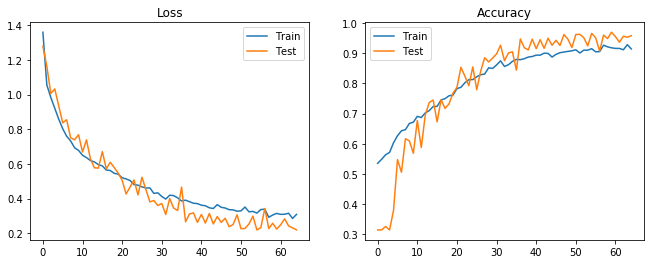

In [34]:
%matplotlib inline
from keras.utils import multi_gpu_model

num_epochs = 150

result_dir=''
# training args
lr = 0.001
lr_decay = 0.

num_trials = 1
patience = 10
store_models = True

best_epoch_acc = []


for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train_z.shape)
    model=multi_gpu_model(model,2)

    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_admci_z_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    history = model.fit(
        X_train_z,
        y_train_z,
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_test_z,y_test_z),
        callbacks=callbacks,
        shuffle=True
    )
    
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Test"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Test"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation

    y_pred_z = model.predict(X_test_z, batch_size=1)


    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])


In [35]:
## acc 
for i in range(2):
    print(np.mean(y_test_z[:,i]==((y_pred_z>=0.5)[:,i])*1))

0.9581218274111675
0.9581218274111675


In [36]:
##tp
for i in range(2):
    print(np.sum((y_pred_z[:,i]>=0.5)*1+y_test_z[:,i]==2)/np.sum(y_test_z[:,i]==1))

0.9444444444444444
0.9879032258064516


In [37]:
##precision
for i in range(2):
    print(np.sum((y_pred_z[:,i]>=0.5)*1+y_test_z[:,i]==2)/np.sum((y_pred_z[:,i]>=0.5)*1==1))

0.9941520467836257
0.8909090909090909


# Voting System

In [49]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

model_x = init_model(path='model_admci_x_trial_0.h5', finetune=False, up_to=None)
model_y = init_model(path='model_admci_y_trial_0.h5', finetune=False, up_to=None)
model_z = init_model(path='model_admci_z_trial_0.h5', finetune=False, up_to=None)


In [50]:
pred_x=model_x.predict(X_test_x)
pred_y=model_y.predict(X_test_y)
pred_z=model_z.predict(X_test_z)


In [51]:
pred=((pred_x+pred_y+pred_z)>=1.5)*1

In [52]:
## acc 
for i in range(2):
    print(np.mean(y_test_z[:,i]==pred[:,i]))

0.9784263959390863
0.9796954314720813


In [53]:
##tp
for i in range(2):
    print(np.sum(pred[:,i]+y_test_z[:,i]==2)/np.sum(y_test_z[:,i]==1))

0.9703703703703703
0.9959677419354839


In [54]:
##precision
for i in range(2):
    print(np.sum(pred[:,i]+y_test_z[:,i]==2)/np.sum(pred[:,i]==1))

0.9980952380952381
0.9427480916030534
